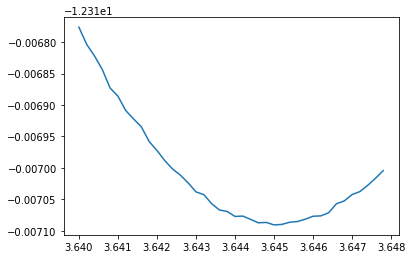

In [3]:
import ase;
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
import matplotlib.pyplot as plt;

Epot = [];
F = [];
al = [3.64+0.0002*i for i in range(40)];
estimator = Estimator(model_version="v2.0.0");
calculator = ASECalculator(estimator);
for a in al:
    pos = [(0,0,0),(1/2,1/2,0),(1/2,0,1/2),(0,1/2,1/2)];
    atoms = ase.Atoms('Cu4',
                  cell=[a, a, a, 90, 90, 90],
                  pbc=(True, True, True),
                  scaled_positions=pos);
    atoms.calc = calculator;
    Epot.append(atoms.get_potential_energy());
    F.append(atoms.get_forces());
plt.plot(al,Epot);

In [7]:
a = 3.645;
import ase;
import numpy as np;
import scipy;
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
import nglview as nv
from itertools import chain
from scipy.sparse import linalg

class configuration(object):
    def __init__(self, box: list, pos: list, supercell: tuple = (1,1,1), element: str = 'Cu', n_atom: int = 4, pbc: list = (True,True,True)): # set computation supercell box = [a, b, c, alpha, beta, gamma]. unit: A, degree
        self.box = [box[i]*supercell[i] for i in range(3)]+box[3:];
        self.element = element;
        self.n_atom = n_atom*supercell[0]*supercell[1]*supercell[2];
        self.pbc = pbc;
        estimator = Estimator(model_version="v2.0.0");
        self.calculator = ASECalculator(estimator);
        self.atoms = ase.Atoms(self.element+str(n_atom),
              cell=box,
              pbc=self.pbc,
              scaled_positions=pos)*supercell;
        self.atoms.calc = self.calculator;
        
        # then we construct a projection operator to transform to mass center coordinate frame
        # readers do not need to understand the details
        one_direction = [[1]*i+[-i]+[0]*(self.n_atom-i-1) for i in range(1, self.n_atom)];
        self.projector = np.matrix([[one_direction[i//3][j//3]*(i%3 == j%3)/np.sqrt((i//3+2)*(i//3+1)) for j in range(3*self.n_atom)] for i in range(3*self.n_atom-3)])
        
    def set_atoms(self, pos:list):    # set atomic positions in the configuration by fraction coordinate list pos = [\vec x_1, ..., \vec x_N]
        self.atoms = ase.Atoms(self.element+str(self.n_atom),
              cell=self.box,
              pbc=self.pbc,
              scaled_positions=pos);
        self.atoms.calc = self.calculator;
        return self.atoms;
    
    def force(self):     # compute force on each atom f = [\vec f_1, ..., \vec f_N]. unit: eV/A
        return self.atoms.get_forces();
    
    def potential(self):   # compute total potential energy. unit: eV
        return self.atoms.get_potential_energy();
    
    def plot_configuration(self):  # plot the atomic configuration
        v = nv.show_ase(self.atoms, viewer="ngl");
        v.add_label(
            color="blue", labelType="text",
            labelText=[self.atoms[i].symbol + str(i) for i in range(self.atoms.get_global_number_of_atoms())],
            zOffset=1.0, attachment='middle_center', radius=1.0
        );
        return v;
    
    def compute_Hessian(self, step: float = 0.01):
        pos = self.atoms.get_scaled_positions();
        cell = self.atoms.get_cell().tolist();
        self.Hessian = [];
        for atom in range(len(pos)):
            for i in range(3):
                b_matrix = conf.atoms.cell.reciprocal().tolist();
                for j in range(3):
                    pos[atom][j] += step*b_matrix[j][i]; 
                self.set_atoms(pos);
                self.Hessian.append(list(chain(*-self.force()/step)));
                for j in range(3):
                    pos[atom][j] -= step*b_matrix[j][i];
        self.set_atoms(pos);
        return self.Hessian;
    
    def compute_vibration_modes(self):
        H_projected = self.projector*self.Hessian*self.projector.T;
        M_reduced = self.projector*np.diag([self.atoms.get_masses()[i//3] for i in range(self.n_atom*3)])*self.projector.T;
        omega2 = scipy.linalg.eigvalsh(H_projected, b =M_reduced);
        self.omega2 = 64.654**2*omega2;
        return self.omega2;
    
box = [a, a, a, 90, 90, 90];
pos = [(0,0,0),(1/2,1/2,0),(1/2,0,1/2),(0,1/2,1/2)];
conf = configuration(box,pos,supercell = (1,1,1));
#print(conf.force());
print(conf.potential());
conf.compute_Hessian();
conf.compute_vibration_modes();
conf.plot_configuration()


-12.317091739685566


NGLWidget()

In [71]:
box = [a, a, a, 90, 90, 90];
pos = [(0,0,0),(1/2,1/2,0),(1/2,0,1/2),(0,1/2,1/2)];
conf = configuration(box,pos,supercell = (1,1,1));
#print(conf.force());
print(conf.potential());

-12.317091020920998


In [18]:
np.sqrt(conf.omega2)

array([19.66746557, 19.66766029, 19.66792244, 19.66809611, 19.66837188,
       19.6685391 , 28.5958134 , 28.59592801, 28.59638883])